<a href="https://colab.research.google.com/github/Aureldns14/GitConcepts/blob/main/MR_Project_Aurelie_DOENS_Elinor_DUPIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='darkred'>**Question A**</font>

# <font color='red'>**a)**</font>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression

filepath = "Natixis_prices.xlsx"
data = pd.read_excel(filepath)
data.columns = ['Date', 'Price']


data['Date'] = data['Date'].astype(str).str.replace(' 00:00:00', '') ## delete "00:00:00"
print(data.head())

         Date  Price
0  2015-01-05  5.424
1  2015-01-06  5.329
2  2015-01-07  5.224
3  2015-01-08  5.453
4  2015-01-09  5.340


In [31]:
print("Nbr of rows:", data.shape[0])

Nbr of rows: 1022


In [32]:
data['Date'] = pd.to_datetime(data['Date']) #convert into a datetime variable

start_date = '2015-01-01'
end_date = '2016-12-31'

data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

In [33]:
print("Nbr of rows:", data.shape[0])

Nbr of rows: 512


In [34]:
data['Returns'] = np.log(data['Price'] / data['Price'].shift(1))
returns = data['Returns'].dropna()

In [35]:
print(data.head())

        Date  Price   Returns
0 2015-01-05  5.424       NaN
1 2015-01-06  5.329 -0.017670
2 2015-01-07  5.224 -0.019900
3 2015-01-08  5.453  0.042903
4 2015-01-09  5.340 -0.020940


In [36]:
def derivative_logistic_kernel(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

In [37]:
range_for_returns = np.linspace(min(returns), max(returns), 1000)

In [38]:
def kernel_density(returns, range_for_returns, h, kernel_function):

    density = np.zeros_like(range_for_returns)
    for i, x in enumerate(range_for_returns):
        kernel_sum = sum(kernel_function((x - val_de_retour) / h) for val_de_retour in returns)
        density[i] = kernel_sum / (len(returns) * h)
    return density

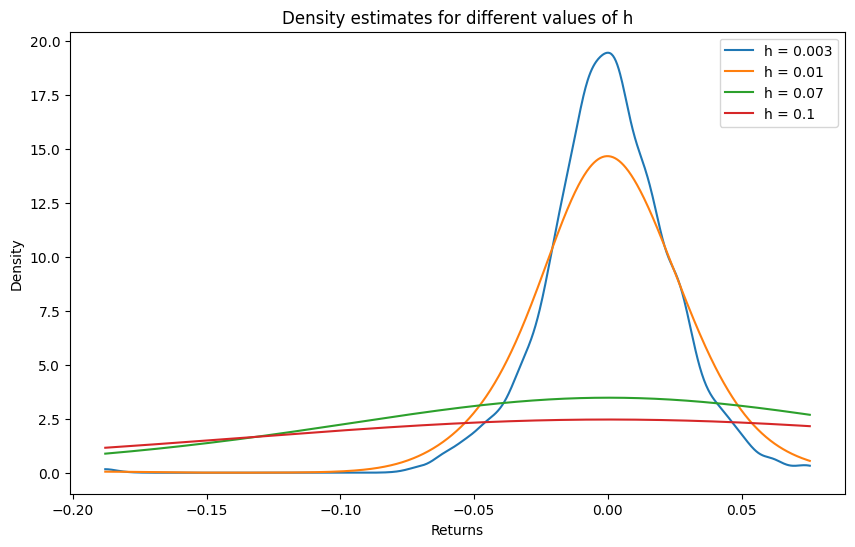

In [39]:
h_values = [0.003, 0.01, 0.07, 0.1]

plt.figure(figsize=(10, 6))

for h in h_values:
    # to calculate the density for each values of h
    density = kernel_density(returns, range_for_returns, h, derivative_logistic_kernel)
    plt.plot(range_for_returns, density, label=f"h = {h}")

plt.title("Density estimates for different values of h")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

In [40]:
def calculate_cdf_trapezoid(density, range_for_returns):
    cdf = np.zeros_like(density)
    for i in range(1, len(density)):
        dx = range_for_returns[i] - range_for_returns[i - 1]
        cdf[i] = cdf[i - 1] + (density[i] + density[i - 1]) * dx / 2
    return cdf / cdf[-1]


def calculate_var(cdf, range_for_returns, alpha):
    var_index = np.searchsorted(cdf, alpha)
    return range_for_returns[var_index]

In [41]:
cdf = calculate_cdf_trapezoid(density, range_for_returns)

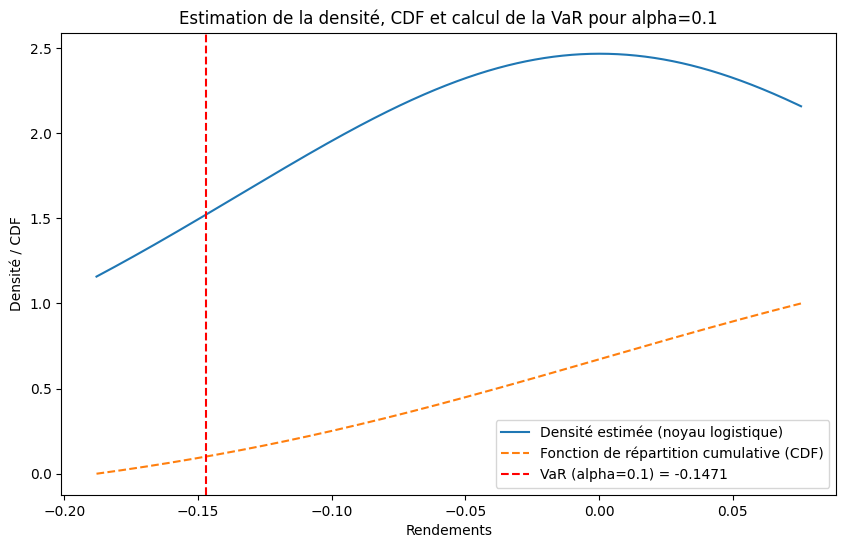

La VaR à 90% est : -0.1471


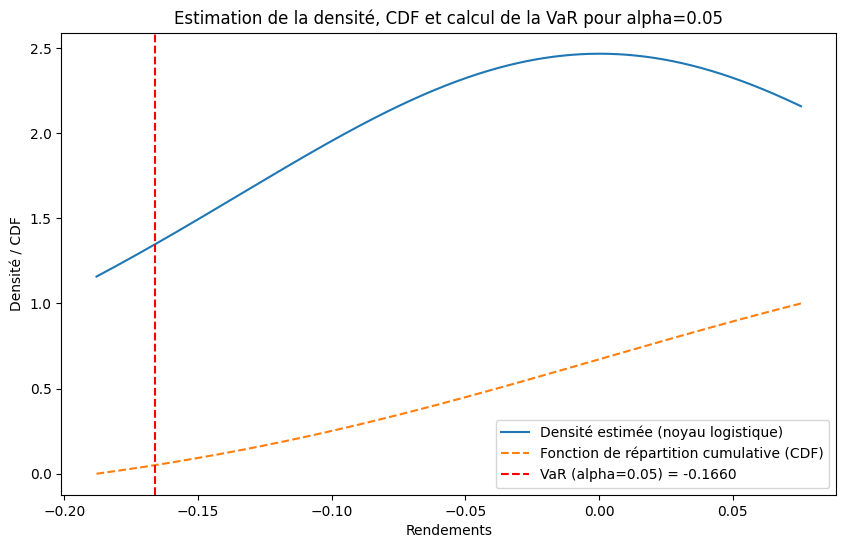

La VaR à 95% est : -0.1660


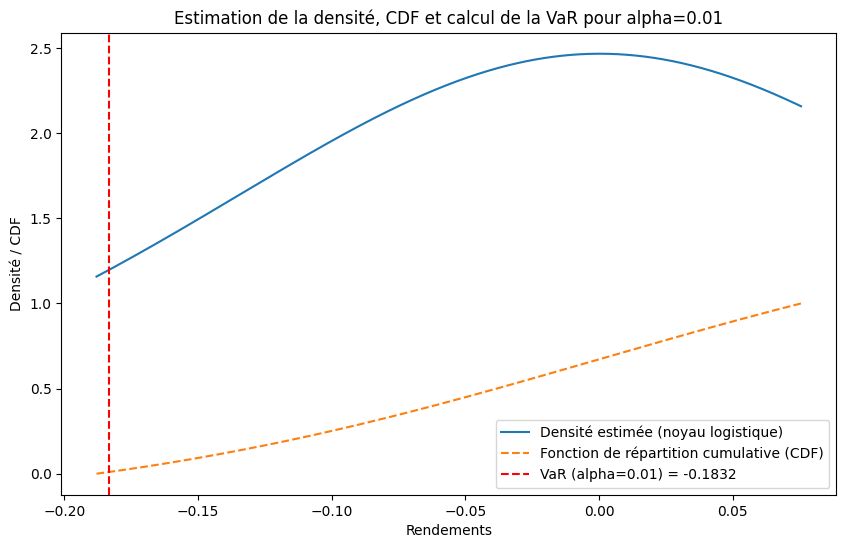

La VaR à 99% est : -0.1832


In [42]:

alpha_values = [0.1, 0.05, 0.01]  #we test various levels of confidence

var_values = {}

for alpha in alpha_values:
    var = calculate_var(cdf, range_for_returns, alpha)
    var_values[alpha] = var

    plt.figure(figsize=(10, 6))
    plt.plot(range_for_returns, density, label="Densité estimée (noyau logistique)")
    plt.plot(range_for_returns, cdf, label="Fonction de répartition cumulative (CDF)", linestyle="--")
    plt.axvline(var, color='red', linestyle='--', label=f"VaR (alpha={alpha}) = {var:.4f}")
    plt.title(f"Estimation de la densité, CDF et calcul de la VaR pour alpha={alpha}")
    plt.xlabel("Rendements")
    plt.ylabel("Densité / CDF")
    plt.legend()
    plt.show()

    print(f"La VaR à {100 * (1 - alpha):.0f}% est : {var:.4f}")

In [43]:
print("\nVaR Results :")
print(f"{'Alpha':<10}{'VaR':<10}")
for alpha, var in var_values.items():
    print(f"{alpha:<10}{var:<10.4f}")


VaR Results :
Alpha     VaR       
0.1       -0.1471   
0.05      -0.1660   
0.01      -0.1832   


# <font color='red'>**b)**</font>

In [44]:
alpha = 0.05
var_05 = var_values[alpha]

exceedances_05 = returns < var_05
proportion_exceeding_05 = np.mean(exceedances_05)

print(f"If alpha = {alpha} (level of confidence = {100 * (1 - alpha):.0f}%) :")
print(f" - VaR : {var_05:.4f}")
print(f" - Proportion of returns exceeding VaR: {proportion_exceeding_05:.4f}")

If alpha = 0.05 (level of confidence = 95%) :
 - VaR : -0.1660
 - Proportion of returns exceeding VaR: 0.0020


# <font color='darkred'>**Question B**</font>

first : we estimate the parameters of a standard Brownian motion on the Natixis stock between 2015 and 2018, using an exponential weighting of the data.

In [45]:
#we will load the data on an other time frame
filepath = "Natixis_prices.xlsx"
data = pd.read_excel(filepath)
data.columns = ['Date', 'Price']
data['Date'] = data['Date'].astype(str).str.replace(' 00:00:00', '')
data['Date'] = pd.to_datetime(data['Date']) #convert into a datetime variable

start_date = '2015-01-01'
end_date = '2017-12-31'
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

In [46]:
data['Returns'] = np.log(data['Price'] / data['Price'].shift(1))
returns_q_b = data['Returns'].dropna()
lambda_ = np.log(2) / 20 # we use a half-life of 20 days wich is usefull to capture recent effects while maintaining stability.
weights = np.exp(-lambda_ * np.arange(len(returns))[::-1])
weights /= weights.sum()

In [47]:
mu = np.sum(weights * returns)
sigma = np.sqrt(np.sum(weights * (returns - mu)**2))

In [48]:
S0 = data['Price'].iloc[-1] #it's the last known price
N = 1000
T = 1/252  # Horizon for one day
Z = np.random.normal(0, 1, N)


Then, we simulate a number N of prices of the stock in a one-day horizon.

In [49]:
simulated_prices = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

In [50]:
# here we transform prices simulated into call prices
K = S0
T_call = 1/12  #for a maturity of one month
simulated_call_prices = []

In [51]:
from scipy.stats import norm
for S in simulated_prices:
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T_call) / (sigma * np.sqrt(T_call))
    d2 = d1 - sigma * np.sqrt(T_call)
    call_price = S * norm.cdf(d1) - K * norm.cdf(d2)  # Formule de Black-Scholes
    simulated_call_prices.append(call_price)


In [52]:
# now we compute the VaR
alpha = 0.05
VaR = np.percentile(simulated_call_prices, alpha * 100)
print(f"VaR à 95% : {VaR:.2f}")

VaR à 95% : 0.01


# <font color='darkred'>**Question C**</font>

# <font color='red'>**a)**</font>

In [53]:
def pickands_estimator(block_maxima):
    block_maxima = np.sort(block_maxima)[::-1]
    k = len(block_maxima) // 4  # Nombre de blocs nécessaires
    if k < 4:
        raise ValueError("There isn't enought maximas to apply the pickands estmator")

    X_nk = block_maxima[k-1]
    X_2k = block_maxima[2*k-1]
    X_4k = block_maxima[4*k-1]
    xi = (1 / np.log(2)) * np.log((X_nk - X_2k) / (X_2k - X_4k))
    return xi


def estimate_mu_sigma_moments(block_maxima, xi):
    mean_maxima = np.mean(block_maxima)
    if xi != 0:
        sigma = np.std(block_maxima) * xi / (1 - xi)
        mu = mean_maxima - (sigma / xi) * (1 - xi)
    else:  # if xi = 0
        sigma = np.std(block_maxima)
        mu = mean_maxima - sigma * np.euler_gamma
    return mu, sigma
#this function is based on the estimator of moment

In [54]:
# we definae thresholds for extreme tail
threshold_gain = np.percentile(returns, 90)
threshold_loss = np.percentile(returns, 10)

extreme_gains = returns[returns > threshold_gain]
extreme_losses = returns[returns < threshold_loss]

In [55]:
block_size = 3
block_maxima_gains = [max(extreme_gains[i:i+block_size]) for i in range(0, len(extreme_gains), block_size) if len(extreme_gains[i:i+block_size]) > 0]
block_maxima_losses = [min(extreme_losses[i:i+block_size]) for i in range(0, len(extreme_losses), block_size) if len(extreme_losses[i:i+block_size]) > 0]

#here we estimate parameters for gains and then for losses
xi_gains = pickands_estimator(block_maxima_gains)
mu_gains, sigma_gains = estimate_mu_sigma_moments(block_maxima_gains, xi_gains)

xi_losses = pickands_estimator(block_maxima_losses)
mu_losses, sigma_losses = estimate_mu_sigma_moments(block_maxima_losses, xi_losses)


print("Extreme gains :")
print(f"xi = {xi_gains:.4f}, mu = {mu_gains:.4f}, sigma = {sigma_gains:.4f}")

print("extreme losses:")
print(f"xi = {xi_losses:.4f}, mu = {mu_losses:.4f}, sigma = {sigma_losses:.4f}")

Extreme gains :
xi = 0.0113, mu = 0.0398, sigma = 0.0001
extreme losses:
xi = -2.3413, mu = -0.0914, sigma = -0.0239


# <font color='red'>**b)**</font>

In [56]:
threshold = np.percentile(returns, 95)
run_length = 3  # Run length to define what is a cluster

exceedances = np.where(returns > threshold)[0]


In [57]:
clusters = []
current_cluster = [exceedances[0]]
for i in range(1, len(exceedances)):
    if exceedances[i] - exceedances[i - 1] <= run_length:
        current_cluster.append(exceedances[i])
    else:
        clusters.append(current_cluster)
        current_cluster = [exceedances[i]]
clusters.append(current_cluster)

# we count number of clusters and exceedances
n_clusters = len(clusters)
n_exceedances = len(exceedances)

# and here we calculate the extremal index
extremal_index = n_clusters / n_exceedances



In [58]:
print(f"Extremal Index for gains: {extremal_index:.4f}")
print(f"Number of clusters: {n_clusters}")
print(f"Number of exceedances: {n_exceedances}")

Extremal Index for gains: 0.7692
Number of clusters: 20
Number of exceedances: 26


In [59]:
threshold = np.percentile(returns, 5)
run_length = 3
exceedances = np.where(returns < threshold)[0]

In [60]:
clusters = []
current_cluster = [exceedances[0]]
for i in range(1, len(exceedances)):
    if exceedances[i] - exceedances[i - 1] <= run_length:
        current_cluster.append(exceedances[i])
    else:
        clusters.append(current_cluster)
        current_cluster = [exceedances[i]]
clusters.append(current_cluster)


n_clusters = len(clusters)
n_exceedances = len(exceedances)

extremal_index = n_clusters / n_exceedances


In [61]:
print(f"Extremal Index for losses: {extremal_index:.4f}")
print(f"Number of clusters: {n_clusters}")
print(f"Number of exceedances: {n_exceedances}")

Extremal Index for losses: 0.7308
Number of clusters: 19
Number of exceedances: 26


# <font color='darkred'>**Question D**</font>

# <font color='red'>**a)**</font>

In [63]:
#importing the data
file_path = "Dataset TD4.xlsx"
data = pd.read_excel(file_path)

#simplifying the column names
data.rename(columns={
    'transaction date (1=1day=24 hours)': 'transaction_date',
    'volume of the transaction (if known)': 'volume',
    'Sign of the transaction': 'transaction_sign',
    'Price (before transaction)': 'price'
}, inplace=True)

print(data.head(5))

   transaction_date  bid-ask spread  volume  transaction_sign    price
0          0.000202          0.1100     8.0                -1  100.000
1          0.001070          0.1030     NaN                 1   99.984
2          0.001496          0.1015     NaN                -1  100.029
3          0.003336          0.0920     NaN                 1   99.979
4          0.003952          0.1106     NaN                 1  100.060


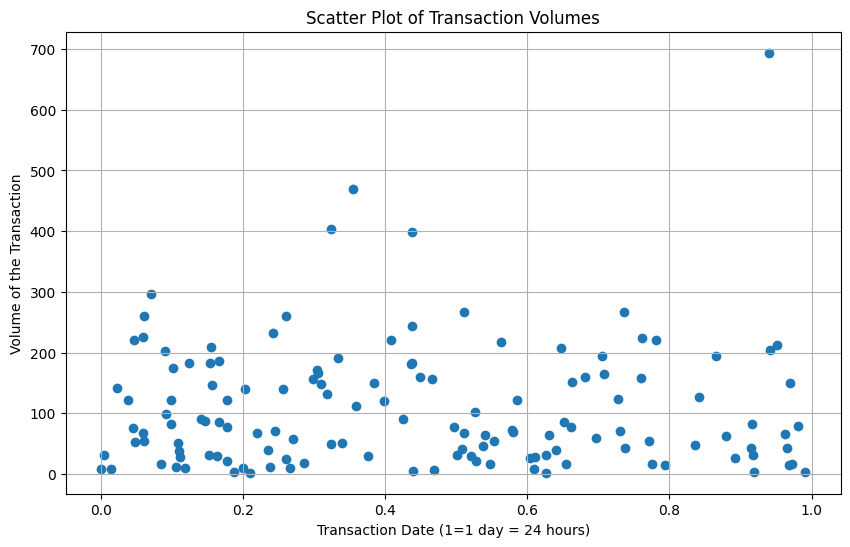

In [64]:
#scatter plot of known volumes
plt.figure(figsize=(10, 6))
plt.scatter(data['transaction_date'], data['volume'])
plt.title('Scatter Plot of Transaction Volumes')
plt.xlabel('Transaction Date (1=1 day = 24 hours)')
plt.ylabel('Volume of the Transaction')
plt.grid(True)
plt.show()

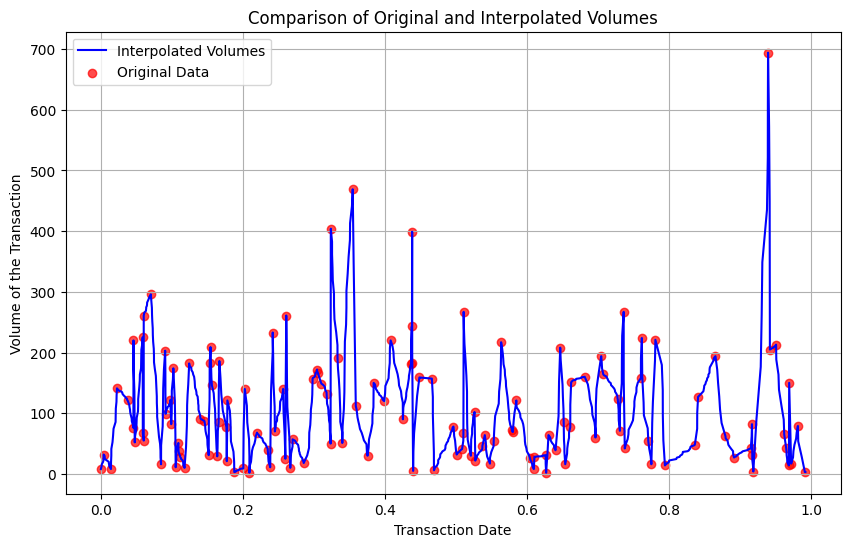

In [65]:
#interpolated volume data
data['volume_interpolated'] = data['volume'].interpolate(method='linear')
plt.figure(figsize=(10, 6))
plt.plot(data['transaction_date'], data['volume_interpolated'], label='Interpolated Volumes', color='blue')
plt.scatter(data['transaction_date'], data['volume'], color='red', alpha=0.7, label='Original Data')
plt.title('Comparison of Original and Interpolated Volumes')
plt.xlabel('Transaction Date')
plt.ylabel('Volume of the Transaction')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
#logarithmic returns calculation
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data = data.dropna()
print(data.head(5))

    transaction_date  bid-ask spread  volume  transaction_sign    price  \
6           0.004074          0.1294    32.0                 1  100.164   
16          0.014393          0.1141     8.0                -1  100.048   
28          0.022861          0.0978   141.0                -1   99.876   
51          0.037864          0.1291   121.0                -1   99.608   
63          0.046006          0.0897    76.0                -1   99.314   

    volume_interpolated   returns  
6                  32.0  0.000040  
16                  8.0 -0.001089  
28                141.0 -0.000881  
51                121.0 -0.000562  
63                 76.0  0.000191  


In [67]:
#calculation of volatility
volatility = data['returns'].std()
print(f"Parameter σ: {volatility}")

Parameter σ: 0.0007387780522343884


In [69]:
#calculation of price variations
data['delta_p'] = data['price'].diff()
#removing null values from delta_p
data = data.dropna()

#calculation of velocity
tau = 1 / 24
data.loc[:, 'v'] = data['volume'] / tau

#linear regression
X = data[['v']]  # explanatory variable
y = data['delta_p']  # target variable

model = LinearRegression()
model.fit(X, y)

gamma = model.coef_[0]
print(f"Parameter γ: {gamma}")

Parameter γ: 1.1947208581463769e-06


In [11]:
X = data[['transaction_sign', 'v']]  # explanatory variables
y = data['delta_p']  # target variable

#linear regression
model = LinearRegression()
model.fit(X, y)

#estimated coefficients
xi = model.coef_[0]
eta = model.coef_[1]

#displaying results
print(f"Parameter ξ: {xi}")
print(f"Parameter η: {eta}")

Parameter ξ: -0.0005938335420168219
Parameter η: 1.573092133913542e-06


In [12]:
#prediction of returns using all coefficients
data['predicted_delta_p'] = (
    xi * data['transaction_sign'] +  # directional impact
    eta * data['v'] +             # transient impact
    gamma * data['v']             # permanent impact
)
residuals = data['delta_p'] - data['predicted_delta_p']

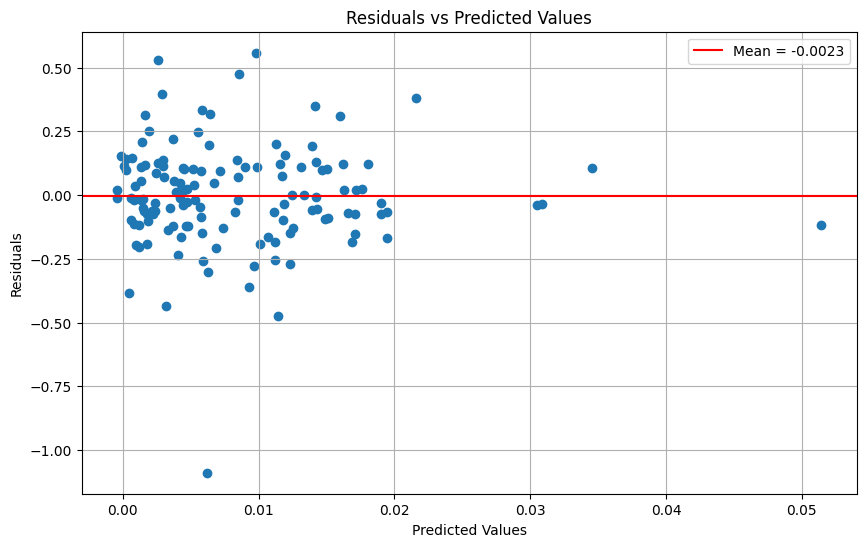

In [13]:
#mean of residuals
mean_residuals = residuals.mean()

#display
plt.figure(figsize=(10, 6))
plt.scatter(data['predicted_delta_p'], residuals)
plt.axhline(mean_residuals, color='red', label=f"Mean = {mean_residuals:.4f}")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

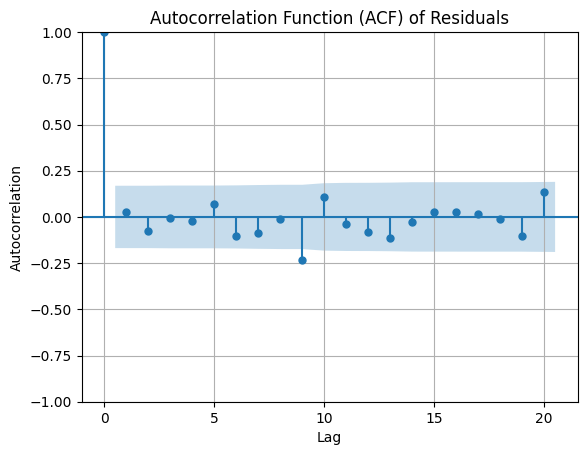

In [14]:
#ACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=20, alpha=0.05)  #alpha=0.05 to display significance thresholds
plt.title("Autocorrelation Function (ACF) of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

# <font color='red'>**b)**</font>

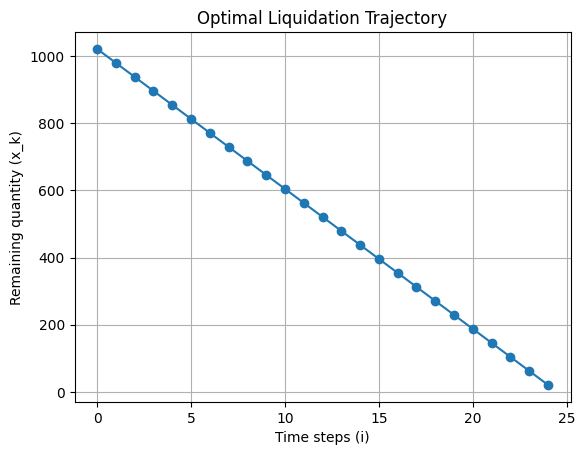

In [15]:
X = 1000  #quantity to liquidate
T = 1  #total liquidation time (1 day)
N = 24  #number of transactions
tau = T / N  #time interval between transactions
risk_aversion = 2e-6

#calculation of K
K = np.sqrt(risk_aversion * volatility**2 / eta)

#calculation of the optimal trajectory
x_k = []
for i in range(N + 1):
    t = i * tau  #time in hours at point i
    x_k_value = X * np.sinh(K * (T - (t - tau / 2))) / np.sinh(K * T)
    x_k.append(x_k_value)

plt.plot(range(N + 1), x_k, marker='o')
plt.title("Optimal Liquidation Trajectory")
plt.xlabel("Time steps (i)")
plt.ylabel("Remaining quantity (x_k)")
plt.grid()
plt.show()

# <font color='darkred'>**Question E**</font>

# <font color='red'>**a)**</font>

In [16]:
#data import
file_path = "Dataset TD5.xlsx"
data = pd.read_excel(file_path)
print(data.head(5))

                   Unnamed: 0 Unnamed: 1 Unnamed: 2  Unnamed: 3  \
0               GBPEUR Curncy        NaN        NaN         NaN   
1                        Date       HIGH        LOW         NaN   
2  2016-03-07 08:59:59.990000     1.2932     1.2917         NaN   
3         2016-03-07 09:15:00      1.294      1.293         NaN   
4         2016-03-07 09:30:00     1.2943     1.2922         NaN   

                   Unnamed: 4 Unnamed: 5 Unnamed: 6  Unnamed: 7  \
0               SEKEUR Curncy        NaN        NaN         NaN   
1                        Date       HIGH        LOW         NaN   
2  2016-03-07 08:59:59.990000    0.10725     0.1072         NaN   
3         2016-03-07 09:15:00    0.10728    0.10717         NaN   
4         2016-03-07 09:30:00    0.10726    0.10719         NaN   

                   Unnamed: 8 Unnamed: 9 Unnamed: 10  
0               CADEUR Curncy        NaN         NaN  
1                        Date       HIGH         LOW  
2  2016-03-07 08:59:59.990000

In [17]:
#data reformatting
currency_pairs = ['GBPEUR', 'SEKEUR', 'CADEUR']
headers = ['Date', 'HIGH', 'LOW']
i=0

for pair in currency_pairs:
    start_col = i * 4 #index of the first column corresponding to the current pair
    df = data.iloc[2:, start_col:start_col+3].copy() #extract the data for the current pair and store it in df

    df.columns = headers #rename the columns of df with 'Date', 'HIGH', 'LOW'

    #ensure the data is extracted in the correct type (float)
    df['HIGH'] = df['HIGH'].astype(float)
    df['LOW'] = df['LOW'].astype(float)

    #store in a dataframe specific to the current pair
    if pair == 'GBPEUR':
        df_GBPEUR = df
    elif pair == 'SEKEUR':
        df_SEKEUR = df
    elif pair == 'CADEUR':
        df_CADEUR = df
    i=i+1

#display the dataframes
print("\nData for GBPEUR:")
print(df_GBPEUR.head())
print("\nData for SEKEUR:")
print(df_SEKEUR.head())
print("\nData for CADEUR:")
print(df_CADEUR.head())


Data for GBPEUR:
                         Date    HIGH     LOW
2  2016-03-07 08:59:59.990000  1.2932  1.2917
3         2016-03-07 09:15:00  1.2940  1.2930
4         2016-03-07 09:30:00  1.2943  1.2922
5         2016-03-07 09:45:00  1.2930  1.2913
6         2016-03-07 10:00:00  1.2931  1.2921

Data for SEKEUR:
                         Date     HIGH      LOW
2  2016-03-07 08:59:59.990000  0.10725  0.10720
3         2016-03-07 09:15:00  0.10728  0.10717
4         2016-03-07 09:30:00  0.10726  0.10719
5         2016-03-07 09:45:00  0.10728  0.10721
6         2016-03-07 10:00:00  0.10725  0.10719

Data for CADEUR:
                         Date    HIGH     LOW
2  2016-03-07 08:59:59.990000  0.6842  0.6829
3         2016-03-07 09:15:00  0.6849  0.6841
4         2016-03-07 09:30:00  0.6844  0.6837
5         2016-03-07 09:45:00  0.6844  0.6839
6         2016-03-07 10:00:00  0.6840  0.6835


In [18]:
#adding a column for average prices for each currency pair
for df in [df_GBPEUR, df_SEKEUR, df_CADEUR]:
    df['Price'] = (df['HIGH'] + df['LOW']) / 2

In [19]:
#adding a column with logarithmic returns
for df in [df_GBPEUR, df_SEKEUR, df_CADEUR]:
    df['Returns'] = np.log(df['Price'] / df['Price'].shift(1))

    df.dropna(inplace=True) #removing null returns

In [20]:
#haar wavelet decomposition
def haar_wavelet(df, levels):
    wavelet_coeffs = []
    dfbis = df.copy()  #working on a copy of the dataframe to keep the original intact

    for level in range(levels):
        approximations = (dfbis[::2] + dfbis[1::2]) / 2  #approximations : scaling function φ
        details = (dfbis[::2] - dfbis[1::2]) / 2  #details : wavelet function ψ
        wavelet_coeffs.append(details)  #adding details to coefficients
        dfbis = approximations  #using approximations of this level as data for the next level

    wavelet_coeffs.append(dfbis)  #adding the global approximation
    return wavelet_coeffs

In [21]:
#haar decomposition application
def apply_haar(df, currency_name, levels):
    returns = df['Returns'].values
    coeffs = haar_wavelet(returns, levels)

    #displaying coefficients
    print(f"Haar coefficients for {currency_name}:")
    level = 1
    for i in range(len(coeffs) - 1):  #iterate over all detail coefficients
        details = coeffs[i]
        print(f"Level {level}: {details[:5]}")  #display the first 5 detail coefficients to avoid clutter
        level += 1  #move to the next level
    print(f"Final approximation at level {levels}: {coeffs[-1][:5]} \n")  #display the last approximation at the final level

#apply haar decomposition on each currency pair
apply_haar(df_GBPEUR, "GBPEUR", 4)
apply_haar(df_SEKEUR, "SEKEUR", 4)
apply_haar(df_CADEUR, "CADEUR", 4)

Haar coefficients for GBPEUR:
Level 1: [ 0.00050269 -0.00059956  0.00011612 -0.00038716  0.00013556]
Level 2: [ 2.80381006e-04 -1.16066129e-04 -2.80743788e-04  9.74135811e-06
 -3.86383126e-05]
Level 3: [ 1.11248232e-04 -1.35427778e-04 -1.25748923e-04 -3.85852599e-05
  1.20692074e-04]
Level 4: [-1.03992463e-04 -1.59547758e-04  9.17099404e-05  3.61977037e-05
 -1.23208362e-04]
Final approximation at level 4: [ 2.17572091e-05  5.31524250e-05  4.82811920e-05 -1.68941750e-05
 -6.03736451e-05] 

Haar coefficients for SEKEUR:
Level 1: [ 5.55111512e-17  2.09822274e-04 -4.66352656e-05 -2.33018685e-05
 -2.09842931e-04]
Level 2: [ 1.16580009e-05 -1.04919834e-04 -1.39892206e-04  3.49941222e-05
  1.98230062e-04]
Level 3: [-3.49712849e-05  5.24718790e-05  5.83324398e-05 -2.15820753e-04
 -2.91058076e-05]
Level 4: [ 4.95486800e-05 -1.02059324e-04 -8.74858803e-05  4.66734936e-05
 -9.33956218e-05]
Final approximation at level 4: [-2.62353960e-05  3.20639888e-05 -8.16498040e-05  1.75053684e-05
 -1.7505368

In [22]:
#storage of haar coefficients for each currency pair
coeffs_GBPEUR = haar_wavelet(df_GBPEUR['Returns'].values, 4)
coeffs_SEKEUR = haar_wavelet(df_SEKEUR['Returns'].values, 4)
coeffs_CADEUR = haar_wavelet(df_CADEUR['Returns'].values, 4)

#initialization of correlation coefficient lists
corr_level_1 = []
corr_level_2 = []
corr_level_3 = []
corr_level_4 = []

#calculation of correlations for each level
for level in range(1, 5):
    if level == 1:  #assign the corresponding list to corr_list for the current level
        corr_list = corr_level_1
    elif level == 2:
        corr_list = corr_level_2
    elif level == 3:
        corr_list = corr_level_3
    elif level == 4:
        corr_list = corr_level_4

    #store haar coefficients for the current level
    data1 = coeffs_GBPEUR[level - 1]
    data2 = coeffs_SEKEUR[level - 1]
    data3 = coeffs_CADEUR[level - 1]

    #compute and add correlations to the list
    corr_list.append(("GBPEUR", "SEKEUR", np.corrcoef(data1, data2)[0, 1]))
    #'calculate the correlation between haar coefficients of GBPEUR and those of CADEUR)
    corr_list.append(("GBPEUR", "CADEUR", np.corrcoef(data1, data3)[0, 1]))
    corr_list.append(("SEKEUR", "CADEUR", np.corrcoef(data2, data3)[0, 1]))

#display results
correlations = [corr_level_1, corr_level_2, corr_level_3, corr_level_4]
level = 1
for corr_level in correlations:  #iterate through each correlation list for each level
    print(f"Level {level}:")
    for item in corr_level:  #each item is a tuple of 3 elements: (currency1, currency2, corr)
        print(f"Correlation between {item[0]} and {item[1]}: {item[2]:.4f}")
    level += 1

Level 1:
Correlation between GBPEUR and SEKEUR: 0.1600
Correlation between GBPEUR and CADEUR: 0.2181
Correlation between SEKEUR and CADEUR: 0.1743
Level 2:
Correlation between GBPEUR and SEKEUR: 0.1399
Correlation between GBPEUR and CADEUR: 0.3276
Correlation between SEKEUR and CADEUR: 0.2537
Level 3:
Correlation between GBPEUR and SEKEUR: 0.3003
Correlation between GBPEUR and CADEUR: 0.2255
Correlation between SEKEUR and CADEUR: 0.1601
Level 4:
Correlation between GBPEUR and SEKEUR: 0.1614
Correlation between GBPEUR and CADEUR: 0.1743
Correlation between SEKEUR and CADEUR: 0.0819


In [23]:
level = 1

for corr_level in correlations:  #iterate through the correlation lists for each level
    mean_corr = sum([item[2] for item in corr_level]) / len(corr_level)  #calculate the average correlation
    print(f"Level {level}: Average correlation = {mean_corr:.4f}")
    level += 1

Level 1: Average correlation = 0.1841
Level 2: Average correlation = 0.2404
Level 3: Average correlation = 0.2286
Level 4: Average correlation = 0.1392


Here, the Epps effect is not clearly visible. Indeed, the correlation does not decrease as we approach level 1. The absence of this effect in our data can be explained by the 15-minute granularity, which is too long to observe the effect, generally visible at very high frequencies (minutes or seconds). Additionally, currency markets are highly liquid and reactive to their environment. This creates similar movements among different assets and, therefore, high correlations between them, even in the short term. This explains why we do not observe a decline in correlation at smaller horizons, as currencies are almost instantaneously linked.






# <font color='red'>**b)**</font>

In [24]:
def hurst_exponent(price):
    #calculation of M2
    M2 = ((price - price.shift(1))**2).mean()  #mean of squared differences
    #calculation of M2'
    M2p = ((price - price.shift(2))**2).mean()  #mean of squared differences with a lag of 2
    #calculation of Hurst exponent
    H = 0.5 * np.log2(M2p / M2)
    return H

In [25]:
#calculation of Hurst exponent
hurst_GBPEUR = hurst_exponent(df_GBPEUR['Price'])
hurst_SEKEUR = hurst_exponent(df_SEKEUR['Price'])
hurst_CADEUR = hurst_exponent(df_CADEUR['Price'])

In [26]:
#calculation of daily volatility
volatility_GBPEUR = np.std(df_GBPEUR['Returns'].values)
volatility_SEKEUR = np.std(df_SEKEUR['Returns'].values)
volatility_CADEUR = np.std(df_CADEUR['Returns'].values)

In [27]:
#calculation of annualized volatilities
annualized_volatility_GBPEUR = volatility_GBPEUR *  (252 * 26) ** hurst_GBPEUR
annualized_volatility_SEKEUR = volatility_SEKEUR * (252 * 26) ** hurst_SEKEUR
annualized_volatility_CADEUR = volatility_CADEUR * (252 * 26) ** hurst_CADEUR

In [28]:
#displaying all our results
results = pd.DataFrame({
    'Currency Pair': ['GBPEUR', 'SEKEUR', 'CADEUR'],
    'Hurst Exponent': [hurst_GBPEUR, hurst_SEKEUR, hurst_CADEUR],
    'Daily Volatility': [volatility_GBPEUR, volatility_SEKEUR, volatility_CADEUR],
    'Annualized Volatility': [annualized_volatility_GBPEUR, annualized_volatility_SEKEUR, annualized_volatility_CADEUR]
})
print(results)

  Currency Pair  Hurst Exponent  Daily Volatility  Annualized Volatility
0        GBPEUR        0.679629          0.000624               0.244727
1        SEKEUR        0.667291          0.000327               0.115174
2        CADEUR        0.668115          0.000506               0.179557


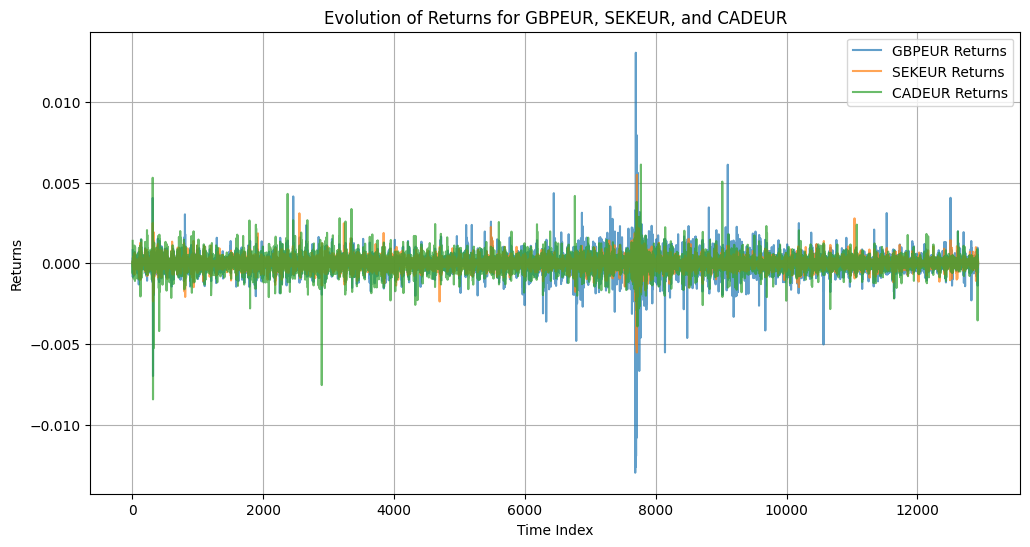

In [29]:
#plot the returns to check if our results are coherent
plt.figure(figsize=(12, 6))

plt.plot(df_GBPEUR['Returns'], label='GBPEUR Returns', alpha=0.7)
plt.plot(df_SEKEUR['Returns'], label='SEKEUR Returns', alpha=0.7)
plt.plot(df_CADEUR['Returns'], label='CADEUR Returns', alpha=0.7)

plt.title("Evolution of Returns for GBPEUR, SEKEUR, and CADEUR")
plt.xlabel("Time Index")
plt.ylabel("Returns")
plt.legend()
plt.grid()
plt.show()


This graph shows that our series is between white noise and mean reverting, which is consistent with Hurst coefficients slightly above 0.5. Our results therefore appear to be reliable.

#**END**